<a href="https://colab.research.google.com/github/wallik2/Hands-on-ML/blob/main/Chapter_2_End_to_End_Machine_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os   #connect to our operating system and our internet
import tarfile #Zip files
import urllib  #Hyperlink files

print('Setup completed')

# <font color=#D42611><u>A) Data Collecting </u></font>

# 1) Get the Data 


In [ ]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
fetch_housing_data()

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
housing = load_housing_data()
housing.head()

# ================================================================

# <font color=#D42611><u>B) Data Exploration </u></font>

# 2) Discover and Visualize the data to gain insight

In [ ]:
housing.info()

In [ ]:
housing["ocean_proximity"].value_counts()

In [ ]:
housing.describe()   #only work for numerical attributes

In [ ]:
#Visualization

%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

# ================================================================

#  3) Data Preparation 

## Split the data to Training  & Testing set 

1) Purely random sampling

- suppose we want to split the training set & testing data in the proportion 0.80:0.20

In [ ]:
import numpy as np

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42) 

2) Stratified sampling

* to prevent bias. supposed you randomly generate but you mostly got the observation that its ocean_proximity is 'NEAR BAY'
* this actually mean that your sampling only has the observations that have ocean_proximity:'NEAR BAY'
* However, too much strata are not good, since each strata will have a small size.
* For this case, each strata is divided by median_income ( this attribute is very important to predict median_housing_price )

In [ ]:
#Cut the dataset to 5 Strata

housing['income_cat'] = pd.cut(housing["median_income"],
         bins=[0, 1.5, 3.0, 4.5, 6., np.inf],
         labels = [1,2,3,4,5])

In [ ]:
housing["income_cat"].hist()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splits = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

#StratifiedShuffleSplit categorized by housing["income_cat"] 
for train_index, test_index in splits.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [ ]:
#Now check the proportion of each Test set strata!

strat_test_set["income_cat"].value_counts() / len(strat_test_set)


#### NOW, Comparing the diff. between purely random sampling & Stratified Sampling 
#####  purely random sampling -> the category proportion is  skewed (BIASED! compare to the full dataset distribution)
##### Stratified Sampling  -> the category proportion is identical to the full dataset which mean this type of sampling has no bias 

In [ ]:
#NOW WE DON'T WANT COLUMN INCOME_CAT ANYMORE, SO WE REMOVE IT

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


In [ ]:
strat_test_set

### CONGRATULATION! YOU HAVE DONE CREATED THE TRAIN & TEST SET

# ==============================================================

# 4) Discover and Visualize the data (to gain insights)

In [ ]:
#we want to play with the training data without harming
housing = strat_train_set.copy()

### Visualize Geographical Data

In [ ]:
housing.plot(kind="scatter",x="longitude",y="latitude")

#High density at latitude=34 & Longtitude=-116 (if you don't believe, you may check the hist. of Latitude and Longitude)

In [ ]:
#High density plot 

housing.plot(kind="scatter",x="longitude",y="latitude", alpha=0.01)

In [ ]:
#The Larger radius of scatter, the larger the population is


housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
            s=housing["population"]/100, label="population", figsize=(10,7)
            )

In [ ]:
#the scatter with the color red is "expensive" ,blue is "cheap"
#the scatter with the larger radius is "a larger population" 

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, 
            s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet")
            )

plt.legend

# s:size ,c:color

### The image tells you that the housing price is related to location(eg. close to the ocean), and to be the population density, so WE MAY CHOOSE CLUSTERING ALGORITHM based on 'ocean_proximity'

# ================================================================

# 5) Looking for Correlations

In [ ]:
# We use Pearson's r

corr_matrix = housing.corr()

In [ ]:
#Now we expected to see the correlation of median_dousing_value and ..... (sort the value of correlation)
corr_matrix["median_house_value"].sort_values(ascending=False)

#Warning: Pearson's r is only measuring for only linear relationship, so it might miss out Non-linear relationships, So don't just judge the explainatory variable using only R or R^2
#

In [ ]:
#In order to avoid that type of missing out Non-linear relationships, we will use scatter matrix instead to see the pattern between variables
#However, we will only pick the only a few promising attributes that seem most correlated with the median housing value

from pandas.plotting import scatter_matrix

attribute = ["median_house_value", "median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attribute], figsize=(12,8));

The most promising attribute to predict the median housing value is THE MEDIAN INCOME

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

#No more hesitate why median housing value has the highest correlation (0.687160)

# ================================================================

# 6) Experimenting with Attribute Combinations

- Since the data told us just the number of the bedroom, but it doesn't tell the # of bedrooms per # of room which to see the proportion between total bedroom and total room 
- Similarly, the total number of room in each household
- Similarly, the number of population in each household

In [ ]:
housing.head()

- So, In order to find 
1.the number of bedroom perhouse hold
2.the number of room per household
3.the number of population per household
- we need to do combination of the attributes (with these following codes)

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]

housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

housing["population_per_household"] = housing["population"]/housing["households"]


In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

- Not Bad! The result shows us that the bedrooms_per_room really matter in the price of median_house_value

- The lower bedrooms_per_room is, the more expensive the house is! 

- Also, the rooms_per_household is somehow matter in the price of median_house_value       
- The higher room per house is, the more expensive the house is (which makes sense, because the l

# ================================================================

# <font color=#D42611><u>C) Data Cleansing </u></font>

# **7) Prepare the Data for Machine learning Algorithms

- This is the preprocessing of the data, including Data cleaning
- Once we created this preprocessing function, next time we can reuse the code of this part to the next raw data

In [ ]:
#But first, let seperate the predictor(x) and label(y)

housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()



# 7.1) Data Cleaning

- Most machine learning cannot work with missing features. As we seen earlier, we saw that total_bedrooms attribute has some missing values

- We have 3 options of handling the missing of values
1.Get rid only the missing value;
2.Get rid the whole column that has the missing values;
3.Fill the missing values with [zero,mean or median, etc.];


In [ ]:
#housing.dropna(subset=["total_bedrooms"])     #option 1

In [ ]:
#housing.drop("total_bedrooms", axis=1)        #option 2

In [ ]:
#median = housing["total_bedrooms"].median()            #option 3 step1 (find median first)
#housing["total_bedrooms"].fillna(median, inplace=True) #option 3 step2 (fill the computed median)

- But doing one of these 3 options manuallly is quite complicated and waste of time
- So, I recommend you to use SKLEARN-SIMPLEINPUTER instead of do it manually (since it can fill all attributes at one single funcction 
- Suppose, we pick the option 3 by using Sklearning SimpleInputer strategy=median)

## 7.1.1) Handling Numerical Attribute

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [ ]:
#Remember that in order to find median. We might need to delete the categorical attributes, and keep only numerical attributes
#which in this dataset, only the attribute Ocean_proximity is the non-numerical attribute
housing_num = housing.drop("ocean_proximity", axis=1)

In [ ]:
#now let's fit our Imputer in this housing_num 
imputer.fit(housing_num)

In [ ]:
#You might wonder the median of every attribute in housing_num
imputer.statistics_

#OR using this (same results)
housing_num.median().values

Now let create the new dataset with data cleaning using our imputer (in X)

In [ ]:
X = imputer.transform(housing_num)

#Noted: the result of X is just the numpy array, so next, we will create in Dataframe form (in housing_tr)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                         index=housing_num.index)
#columns is the name of all columns

In [ ]:
#Now, let check the number of row of each attribute
#You can now see there are no missing value in Training data (all is 16512)
housing_tr.info()

## 7.1.2) Handling Text and Categorical Attributes 

- We once only dealt with numerical attribute, and we ignote this one attribute; the ocean_proximity attribute
- Let's take a look at first 10 rows of ocean_proximility 

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

- you will see that this is NOT arbitrary text (random), but it's a category, so we can change the categories into a number for each category. (Machine learning prefer to work with number more than text

- !!!So, we will use OrdinalEncoder to convert the categories to a number

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) #Using fit_transform can reduce the steps: fit-->transform
housing_cat_encoded[:10]

- Ordinal Encoding give us 1D array, which is not really good for this case
- Ordinal Encoding is often good to use for ordered categories such as Very Bad ,Bad, Average, Good, Excellent  
- But for ocean_proximity is not oredered categories, so the numbers (0 1 2 3 4) are meaningless to predict

So, to fix this problem. We consider using 'OneHotEncoder' than OrdinalEncoder for ocean_proximity

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

#Notice that the output is SciPy sparse Matrix instead of NumPyArray
#THis kind of output is very useful if we have reached up to 1000 categories, because the matrix will be 
#full of zeroelement except just single 1 per row

THis kind of output is very useful if we have reached up to 1000 categories
- Dense Matrix: The matrix is full of zero elements except just single 1 per row.( Drawbacks: Very wasteful of memory mostly to store zero element

- Sparse Matrix: the matrix that only store Non-Zero elements (Pros: don't have to be wasteful of memories with the unnecessary zero elements)

If you don't get it: https://matteding.github.io/images/sparse_dense.gif

In [ ]:
#But if you prefer to see NumPy Dense matrix :

housing_cat_1hot.toarray()

In [ ]:
#Once again, you can get the list of all categories inside the housing's ocean_proximity

cat_encoder.categories_

# 7.2) Custom Transformers 

Although, ScikitLearn provide a lot of great tranformer such as SimpleImputer or OrdinalEncoder, but sometime the scikitLearn doesn't provide our needed transformation; such as adding the combination Attribute, Luckily, we can do this kind of transformation manually. After we have done created the transformation, we can now put to our Transformation Pipeline which will be in step8)

## <u>Scenario 1</u> : should we add bedrooms_per_room as the attribute or not?


- Suppose you want to know that should we included the attribute bedrooms_per_room as a feature for predicting or not, But it is too complicated to create and clean the both dataset in a ton of codes to done created these 2 dataset

- So, We need to create a function that can create a dataset with or without the attribute bedrooms_per_room 

- Basically, just the normal pipeline which provide an option for you whether to include that attribute or not


In [ ]:
# X: the Imputer Transformed dataset


from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [ ]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):                           #Initiate the method inside self
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

## <u>Case 1</u> : Have extra bedrooms_per_room

In [ ]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
housing_extra_attribs

- In this example the Transformer only take one hyperparameter, add_bedrooms_per_room
- This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithm or not!!

- Moreover, You can add more hyperparameter (not only just add_bedrooms_per_room) to gate any data preparation steps.
- The more you automate these data preparation steps, the more combination you can automatically try out, making it much more likely that you will find a great combination of atttributes ( which drastically saving you a lot of time

- This is different from Tranformation Pipelines that ScikitLearn provided!, because you have put an ew option that Tranformation Pipelines didn't provide, which is adding one more hyperparameter: add_bedrooms_per_room

For simply, Just add one more filter to make sure that do you want to have this attribute in the pipeline or not

- We will focus on Tranformation Pipelines that Scikit provided in Section 10

In [ ]:
housing_extra_bedroom = pd.DataFrame(housing_extra_attribs,
                index=housing_num.index,
                columns=housing.columns.to_list()+['rooms_per_household', 'population_per_household', 'bedrooms_per_room'])

In [ ]:
housing_extra_bedroom

In [ ]:
housing.columns

## <u>Case 2</u> : Don't have extra bedrooms_per_room

In [ ]:
attr_adder_2 = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs_2 = attr_adder_2.transform(housing.values)

In [ ]:
housing_No_extra_bedroom = pd.DataFrame(housing_extra_attribs_2,
                index=housing_num.index,
                columns=housing.columns.to_list()+['rooms_per_household', 'population_per_household'])

In [ ]:
housing_No_extra_bedroom

Now, You can get the two datasets that are different in having the attribute 'bedrooms_per_room' within just 3 line of codes for each dataset


# 7.3) Feature Scaling

- One of the most importance transformations 
- Machine Learning Algorithm don't perform well when the numerical attributes have very different scales 

#### Let analyze which attributes have very different scales

In [ ]:
#housing

In [ ]:
#housing["total_rooms"].describe()

In [ ]:
#housing["median_income"].describe()

As you can see the attribute Total_rooms & Median_income has very different scales
- Total_rooms -> ranges from 6 to 39320
- Median_income -> ranges from 0 to 15

Since these 2 attributes that does have very different scales
! So, we can must apply Feature scaling. which will be included in next transformation ; Transformation Pipeline

 ### There are 2 common ways to get all attributes to have the same scale:
 1) min-max scaling (Normalization) <br>
 2) standardization

For more details : https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/

### <font color=#D42611>Warning</font>: You can only apply scaling only at the 'training data', not to the full dataset

In [ ]:
# Use this when the distribution of the data DOES NOT follow a Gaussian distribution
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Use this when the distribution of the data follow a Gaussian distribution
from sklearn.preprocessing import StandardScaler

We will pick Standardization as our feature scaler for some reason !

# ================================================================

# 8) Transformation Pipeline

- Finally, It's time to deliver all 3 ingredients (transformations): SimpleImputer, Custom Transformation, and Standardization to our boiling pot (Pipeline) 
- Note that this pipeline is for only numerical attributes 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler #one of our ingredients: Standardization

In [ ]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()) 
])

In [ ]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
#housing_num_tr

#### - Congratulation, we have done created the numerical attributes handler pipeline, but it is not completed yet.
You still need to transform the remaining categorical attributes which is ocean_proximity

#### - Wouldn't it be better if we create a full pipeline that can handle both numerical attributes and categorical attribute within the same pipeline. 
Luckily, ScikitLearn introduced ColumnTransformer for this purpose which make us able to combine the appropriated transformer for each appropriated attribute

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

In [ ]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)    
])

#apply num_pipeline to numerical attributes only
#apply OneHotEncoder to categorical attributes only

In [ ]:
housing_prepared = full_pipeline.fit_transform(housing)

In [ ]:
housing_prepared[1]

- <font color=Blue>Notes</font> : Since Num_pipeline returns a dense matrix, while OneHotEncoder returns a sparse matrix
- When there is such a mix of sparse and dense matrices. ColumnTransformer will choose the matrix type that has higher density
- In this case, ColumnTransformer choose to return dense matrix (since the numerical attribs has far higher dimensions)

In [ ]:
Attrib_Full = housing_extra_bedroom.columns.to_list()
Attrib_Full.remove('ocean_proximity')

Attrib_Full = Attrib_Full + cat_encoder.categories_[0].tolist()


In [ ]:
pd.DataFrame(housing_prepared, index=housing.index
            ,columns = Attrib_Full)

### Congratulation, We have done cooking the preprocessed dataset which will be used in Next Section; Train a model

# ================================================================

# <font color=#D42611><u>D) Model Training </u></font>

# 9) Training & Evaluating on the Training Set

We will explore how we pick a model step by step, and do some analyze about the evaluation of the model

<b><u>(Spoil:)</u></b> We will use 3 models to training our model respectively: 
- 1) Linear Regression
- 2) Decision Tree Regressor
- 3) Random Forest <br><br>

<b><u>(Spoil 2:)</u></b> We also focus on <b>Cross-Validation</b> which used to detect the problem from overfitting model of Decision Tree Regressor


# 9.1) Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

#housing_prepared : X of training set
#housing_labels : y of training set

#### Finally, We have done creating the linear regression model. Now let's predict some of training set

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)   #don't forget to transform 

#housing: the full training set included in X & y

In [ ]:
print(" The Prediction values:", lin_reg.predict(some_data_prepared))

print("\n","The Actual values:", list(some_labels))

#### - The predicted values VS The actual values is NOT exactly accurate, Now let's measure the whole predicted value error using Root Mean Square Error

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
housing_predictions = lin_reg.predict(housing_prepared)

lin_mse = mean_squared_error(housing_labels,housing_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_rmse

# ---------------------------------------------------------------------------------------------

### <font color=#D42611><u> Score Result </u>: Not a great score</font>
- Since most district's median_housing_values range is between 120000 and 265000. <br>
so, a typical prediction error of 68628 is not very satisfying

###     In this case: Linear regression model is a model underfitting of training data
- it can mean that the features do not provide information to make good predictions, or that the model is not powerful enough..... <br><br>
### <u>Tips</u> : What should we do next if we get the underfitting model of training data?
- 1) Try to find a more powerful model such as Decision Tree, Random Forest 
- 2) Add more features ( e.g.,the log of the population) <br><br>
But, we will pick Choice 1 first, Next we will try DecisionTree model

# ---------------------------------------------------------------------------------------------

# 9.2) Decision Tree Regressor

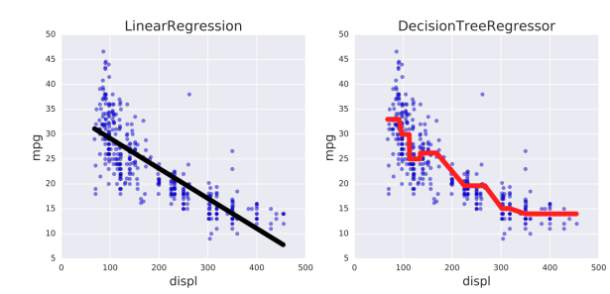


In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

#Now, we trained the decision tree regressor model

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)   #Predict to training set itself

In [ ]:
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

tree_rmse

### --------------------------------------------------------------------------------------------------------------------------------------------------------

### <font color=#D42611><u> We detected a problem !</u></font>
- Wait what!!?? No error at all, Does this model really be absolutely perfect?
- Of course, This model has badly <u>overfit</u> the data. How can you be sure?
Should we now run launch model without any doubt to the test set?




### <font color=#73A417><u> Handle Overfitting model</u></font>


- To be confident of our performance of the model, we should not test on purely training set, It is biased. You are too greedy to use whole training set to train the model and don't remain any set for testing the performance.( regardless the test set, because we avoid to launch the model without confidence and evaluate performance though untouchable test set) 

- To handle this problem, we must split our training set into <br>
1. Smaller Training set (which use to train the model) br>
2. Validation set (use to estimate the model, and tune the hyperparameter of model to find the best performance of the model) <br>

The method of spliting the training set to a smaller training set and validation set called <b><u>Cross-Validation</u></b> which we will focus in next <br><br>

Some useful ref.: https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f
### --------------------------------------------------------------------------------------------------------------------------------------------------------


# Extent  : <u>Better Evaluation using Cross-Validation</u>
<br><br><br>

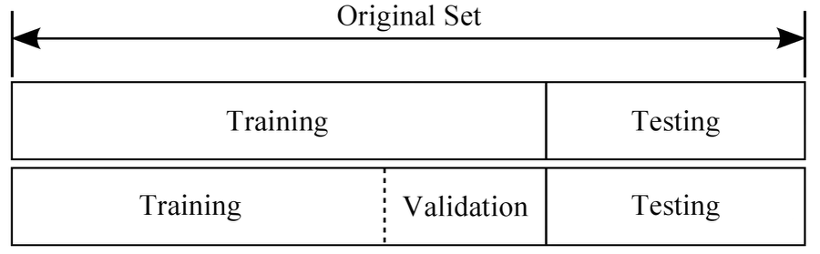


###  <u>Step 1)</u> We have two choices to do cross-validation
![gff.png]()
<b>1) using train_test_split()</b> <br> 
=> randomly Split the training set into a smaller training set and validaation set in a given proportion <br><br>
<b>2) using K-Fold cross validation (recommended!) </b><br>
=> randomly split the training set to k distinct subsets called folds, then evaluate the Decision tree model k time, picking a different fold for evaluation everytime and training on the other k-1 folds. The result is an array containing the 10 evaluation scores


### <u>Step 2)</u> We will pick <i>K-Fold cross validation</i> to split the training set

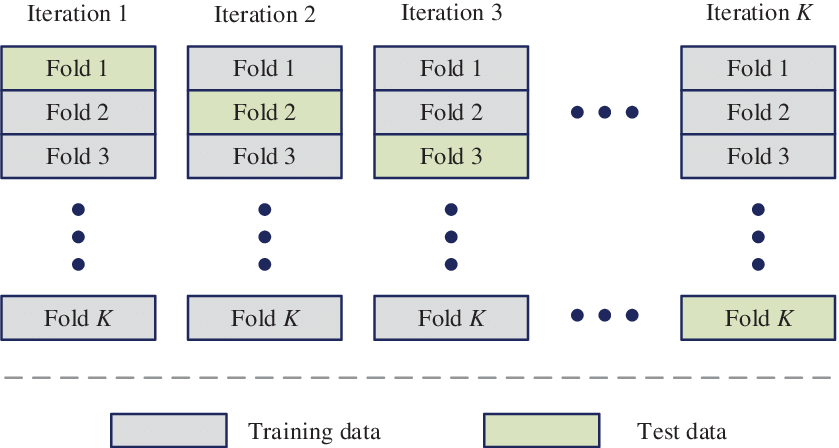

### 1) K-Fold cross validation on <u>Decision Tree Regressor</u>

The following code randomly splits the training set to 10 distinct subsets called <i>folds</i>

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

#using negative mean squared error because the utility function of ScikitLearn is 'greater is better'

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [ ]:
display_scores(tree_rmse_scores)

### <font color=#D42611><u> Results:</u></font> Now, the Decision Tree doesn't look as good as it did earlier ! : Score = 70571.65 ± 2772.07056
<br> - the Decision Tree score is approximately <b>70571.65 ± 2772.07056930079</b> (can be varied every time you rerun tree_rsme_scores)
<br> - which is worse than the previous linear regression, but you might say that this is biased, the Linear regression used the the different evaluation, so Next we will do compare 

# ------------------------------------------------------------------------------------------------------------

### 2) K-Fold cross validation on <u>Linear Regression</u>

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)

In [ ]:
display_scores(lin_rmse_scores)

### <font color=#D42611><u> Results:</u></font> That's Right, Linear regression is better than Decision tree regressor: Score = 69052.46136345083 ± 2731.6740017
<br> - the Linear regression score is approximately <b>69052.46136345083
 ± 2731.674001798346</b> (can be varied every time you rerun lin_rsme_scores)
<br> - This can be interpeted that the decision tree regressor is overfitting so badly that it performs worse than the Linear Regression Model.


# ---------------------------------------------------------------------------------------------------------------

# 9.3) Random Forest Regressor

- Now let try our last model : the RandomForestRegressor

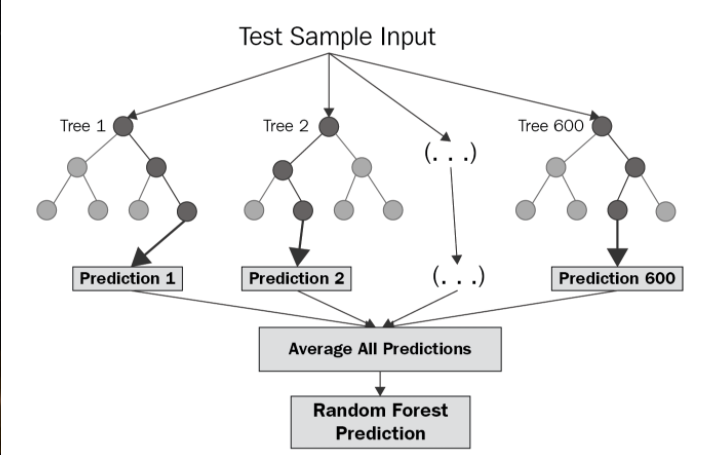

- Random forests works by training many Decision Trees on random subsets of the features, then averaging out their predictions

- It's an example model of <i>Ensemble Learning</i> which is Building a model on top of many other models, It is often a great way to push ML Algorithm even further.


In [ ]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

### <u>Evaluation 1</u> : Evaluate the score on purely training set

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)

forest_mse = mean_squared_error(housing_labels,housing_predictions)
forest_rsme = np.sqrt(forest_mse)

In [ ]:
forest_rsme

### <u>Evaluation 2 </u>: Evaluate scores using K-Fold Cross Validation 

In [ ]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                         scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)

In [ ]:
display_scores(forest_rmse_scores)

### <font color=#D42611><u> Results:</u></font> Wow, This is much better, Random Forest regressor provide a very promising score than the other models : Score = 50173.15202533749 ± 1893.5778795944082
<br> - the Random Forest Regressor Score is approximately <b>50173.15202533749 ± 1893.5778795944082</b> (can be varied every time you rerun forest_rsme_scores)
<br> <font color=#D42611><b> !!!</b></font>- But If you compare Evaluation 1 & Evaluation 2 score: the score on the training set is still much lower than on the validation sets, meaning that <u>the model is still overfitting the training set</u>

### <font color=#73A417><u> Possible Solutions for overfitting</u></font> : 
- To simplify the model 
- Constrain (i.e.,regulize it)
- Get a lot more training data. Before you dive much deeper into Random Forests
,However you should try a lot of more machine learning algorithms ( e.g. Support vector Machines with different kernels, and possiby a neural network), without spending too much time tweaking the hyperparameters
- The goal is to shortlist a few (2 to 5) promising model



# ================================================================

# 10) Fine-Tune Your model

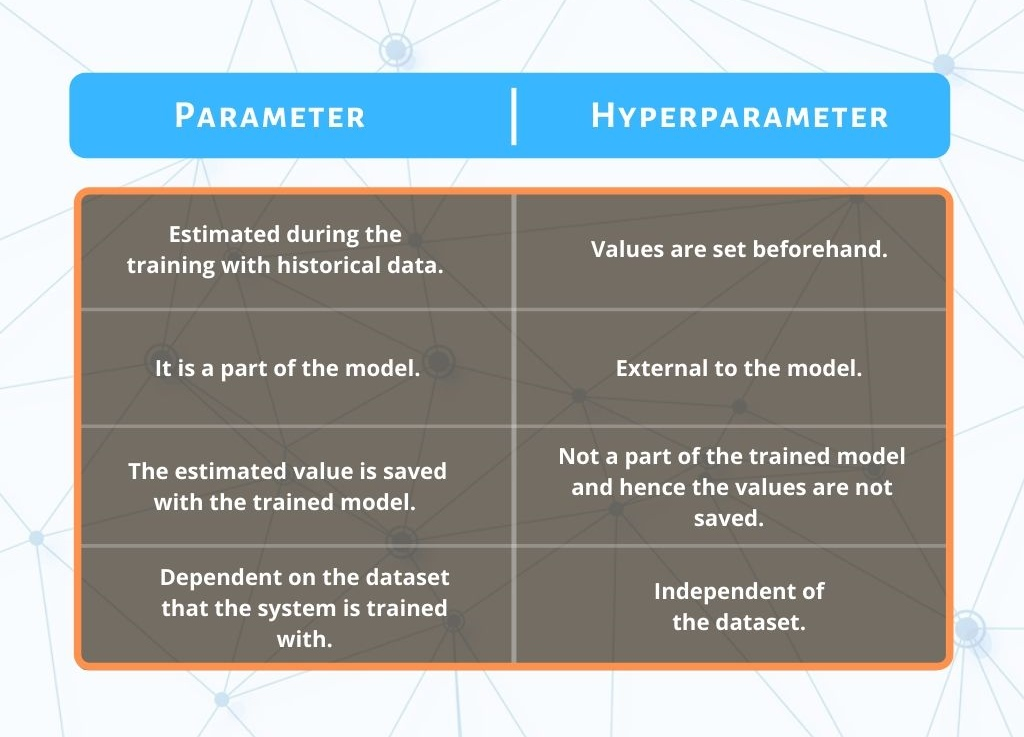

- In this section, Assume that we have chosen <u>Random Forest Regressor</u> as our model <br>
- But, you know what, you can set the parameter inside the model which called 'hyperparameter'<br>
and you can find the best hyperparameter to adjust the Random forest regressor for optimizing the best score of prediction<br>
- The reason you need to adjest the hyperparameter is because the default hyperparameter that you used in the model might not be an optimal model

<b>"Tuning Machine Learning Model Is Like Rotating TV Switches and Knobs Until You Get A Clearer Signal"</b>

Ref: https://medium.com/fintechexplained/how-to-fine-tune-your-machine-learning-models-to-improve-forecasting-accuracy-e18e67e58898

<h2>There are <b>3 ways</b> to approach with the hyperparameters manually <br></h2>
1) Grid Search <br>
2) Randomized Search <br>
3) Ensemble Method

# --------------------------------------------------------------------------------------------------------------

# 10.1) Grid Search

Hyperparameter we will focus in our random forest regressor model is <br>
1) n_estimator , 2) max_features

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = [
    {'n_estimators': [3,10,30], 'max_features':[2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators':[3,10], 'max_features':[2, 3, 4]},
]

forest_reg = RandomForestRegressor()


#First dict, The Grid Search will pair n_estimator: 3 and to all max_feature : 2, 4, 6, 8 , Similarly, n_estimator: 10 and 30 : which means all pairs will be 
#[(3,2),(3,4),(3,6),(3,8),(10,2),(10,4),.....(30,6),(30,8)] which total combinations are 3*4 = 12

#Similarly, After done doing the first dict, we will do the 2nd dict (which set bootstrap = False) Grid Search which contain
#[(3,2),(3,3),(3,4),(10,2),(10,3),(10,4)] which total combinations are 2*3 = 6

#So total combinations that we will do are 12 + 6 = 18 Combinations


In [ ]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score = True)

#Since we are using 5 fold cross validation; this mean we will train each model 5 times
#So, there will be 18*5 = 90 rounds of training. This is why using Grid Search using so long time

In [ ]:
grid_search.fit(housing_prepared, housing_labels)

In [ ]:
grid_search.best_params_

In [ ]:
#How can you derive your best model ?
# Just use this
grid_search.best_estimator_

#This will make you obtain the RandomForestRegressor with max_feature=8 and n_estimator=30

### <font color=green><u> Results:</u></font> : There we go, Our best hyperparameters from the given 18 combinations are
1) max_feature : 8 <br>
2) n_estimators : 30

### <font color=#D42611><u> Warning !</u></font> : However, since 8 and 30 are the maximum values that were evaluated, so we should probably try searching for the higher value; the score may continue to improve

# --------------------------------------------------------------------------------------------------------------

### Let see the evaluation scores of all estimators !

In [ ]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score),params)

- As you can see, we obtain the best solution by setting the <b>max_features hyperparameter to 8 </b>. and the <b>n_estimators hyperparameter to 30</b>

- The RMSE score for this combination is 50018.837 which is slightly better than the score you got earlier which is 50173.15202533749

-  <font color=#D42611>But! Remember that this combination might not be the best hyperparameter, since you can also add up more <b>max_features</b> and <b>n_estimators</b> such as (max_features,n_estimator) = (15,40)

# --------------------------------------------------------------------------------------------------------------

# 10.2) Randomized Search

- As we know that If the total combinations of Grid Search are very large, it will waste your time a lot

- So, Randomized Search has been introduced to stop this problem.
- Suppose from the previous Grid Search, you have 90 combinations, and it forces you to run all 90 combinations to done the task, while If you use Randomized Search instead, you can set <u>the number of iterations</u> which determine how many comnications you want to run with in the given scope.

'n_estimators': [3,10,30], 'max_features':[2, 4, 6, 8]  

## <u>Ex 1</u>: 

given n_estimators: [3,10,30], max_features:[2, 4, 6, 8]  

### <font color=#D42611><u> Problem:</u></font> As you can see the total combinations are 3*4 = 12 but suppose you don't want to run all combination. you just want to run only 5 combinations 

### <font color=green><u> Solution :</u></font> Just set Number_Iterations = 5, then only 5 combinations will be shown.  
you will get something like [3,4],[30,2],[30,8],[10,4],[3,2]

# --------------------------------------------------------------------------------------------------------------

## <u>TIPS</u>: Pros and Cons of Grid Search & Randomized Search


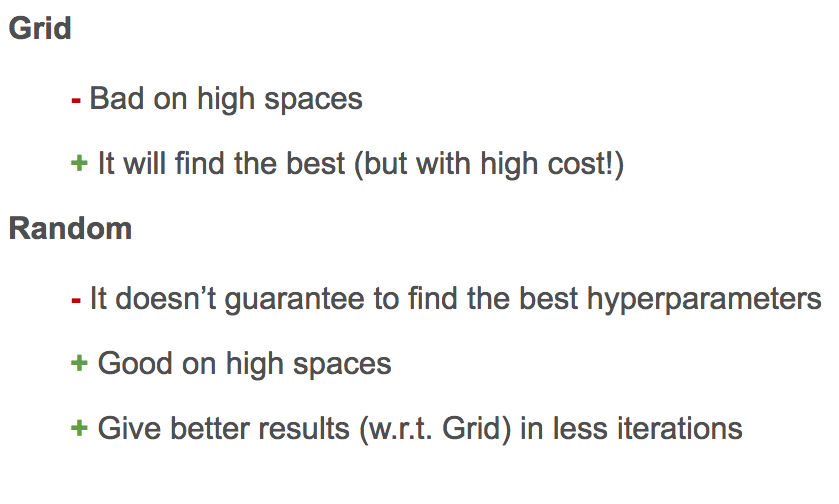

# --------------------------------------------------------------------------------------------------------------

# 10.3) Ensemble Method

- This might not be new for you, since Random Forests itself is a typical model of Ensemble Method
- just like Random forests perform better than the individual Decision Trees they rely on
- We don't focus much in this chapter (will be more focused in chapter 7)

# ================================================================

# 11) Analyze the Best Models and Their Errors

- Once you get the best model with the best hyperparameter, you may find it interesting to particularly gain insight of the best model

- The RandomForestRegressor can indicate the relative importance of each attribute for making accurate prediction
So we can see that which attribute help RandomForestRegressor predicted better

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_

feature_importances

In [ ]:
sorted(zip(feature_importances,Attrib_Full),reverse=True)

<u> Interpretation </u> : The <b>higher</b> the value is, the more importance that attribute is useful and important for predicting by RandomForestRegressor <br>
- As you can see that the attribute <i>median_income</i> is the best helping hand for the accurate model prediction

- Oppositely, you might see <i>NEAR OCEAN, NEAR BAY, and especially ISLAND</i> are the most helpless attributes, so you may want to try dropping some of these 3 attributes. So, only one <i>ocean_proximility</i> category; 1H OCEAN will still exist

### <u> Shine your Idea </u>

- Just like R-squared Correlation, the higher it is, the stronger relation between the explainatory variables and the response variable is, But R-squared is measured via Linear relationship

- So to evaluate the relationship based on random forest regressor pattern between the single attribute and response variable, we use this instead of R-squared

### <u> What's the point of this section 11</u>
- You should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the proble, (adding extra features or getting rid of uninformative ones, cleaning up outliers, etc.)
- In this section, we did that by investigating the worst attributes that create the error for our model RandomForestRegressor as the most, Now it's up to you deciding to get rid of these 3 attributes or not. (but follow to the textbook, they decided not to remove those attributes)

# ================================================================

# 12) Evaluate your system on the Test set

- Finally, We decided to lauch our model after tweaking our model for a while.
- Now, it's time to evaluate our Final model: the RandomForestRegressor Model with max_feature=8 and n_estimators=30 on the test set

In [ ]:
final_model = grid_search.best_estimator_

In [ ]:
X_test = strat_test_set.drop("median_house_value",axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [ ]:
X_test_prepared = full_pipeline.transform(X_test)                               

#Cleaning the X_test (fill up the missing value using SimpleImputer, adding the extra attribute, oneHotEncoder)

In [ ]:
final_predictions = final_model.predict(X_test_prepared)

In [ ]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

- Remember, we can even search for the better hyperparamaters, but how to estimate that the newer model will be the better model than this one. 
- Sure, you might consider set the confidence interval, if it is in rejection zone, then we can replace the new model instead of this model (This is also how we apply statistics)

Suppose we want 95% confident interval
- This is left tailed test
- H0 : The performance of the old model is the same as the new model
- HA : The performance of the old model is worse than the new model 

In [ ]:
from scipy import stats

In [ ]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                        loc=squared_errors.mean(),
                        scale=stats.sem(squared_errors)))

If the new model's performance score is lower than 45730.04514308, then reject H0, and allow replace the old model by the new model


# 13) Launch, Monitor, and Maintain your System

- Now, You got approval to launch the model, You now need to get your solution ready for production (e.g., polish the code, write documentation and tests, and so on). 
- Then you can deploy your model to your production environment. One way to do this is to save the trained Scikit-Learning model (e.g., using joblib), including the full preprocessing and prediction pipeline, then load this trained model within your production environment and use it to make prediction..

- Note that models tend to rot over time, so we must monitor the live performance, and gain new insight and create a new model to adapt as time passed

- Also, make sure to keep backups of every model you create, you will be able to roll back to a previous model, in case the new model might start failing badly for some reason, so we must quickly do back up the previous model, this also can be such a way to compare the new model and the old model

# -------------------------------------The End--------------------------------------------------------

Nope, never have the end. you still need to do live performance, to keep in track and find the best model in that current time

# <u> Exercise </u>

### <u>Ex1</u>: Try the Support Vector Regressor (and find the best hyperparamater for it!)

In [ ]:
from sklearn.svm import SVR


In [ ]:
support_vector_regressor = SVR()                                     #Remember that this is a support vector REGRESSOR 

support_vector_regressor.fit(housing_prepared,housing_labels)      
housing_prediction = support_vector_regressor.predict(housing_prepared)

In [ ]:
svr_mse = mean_squared_error(housing_prediction,housing_labels)
svr_rmse = np.sqrt(svr_mse)

svr_rmse

Now root mean square error is extremely higher than our previous 3 models; which mean it doesn't perform very well, but we still can fine tune this model.

In [ ]:
param_grid_svm = [{'kernel': ['linear'] ,'C': [3,10,30], 'gamma':[20, 40, 60, 80]},
                  {'kernel':['rbf'],'C':[1,10,20], 'gamma':[2,16,600]}]
    

Grid_Search_SVM = GridSearchCV(support_vector_regressor, param_grid_svm, cv=5,
                          scoring='neg_mean_squared_error',
                          verbose = 2)


In [ ]:
Grid_Search_SVM.fit(housing_prepared, housing_labels)

In [ ]:
Grid_Search_SVM.best_params_

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

#The best model achieves the following score (evaluated using 5-fold cross validation):

- As you can see 'SVM with hyperparameter C=30, gamma=20, and kernel=linear makes us the very good score which is as good as our previous Random Forest Regressor

- However, As you can see that C=30 is the maximum of krnel=linear, so next time you might try deleting C=3,10 and then replace the value of C which is more than 30, Oppositely, gamma=20 is the lowest value, so you might try replacing some lower value than 20, which I'm sure it will provide us such a better score.

- Next time, We will try using Randomized search, As you can see that doing Grid Search wastes a lot of time (20 minute spproximately)

### <u>Ex2</u>: Try replacing GridSearch with RandomizedSearchCV !

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"

In [ ]:
param_grid = [
    {'n_estimators': [3,10,30], 'max_features':[2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators':[3,10], 'max_features':[2, 3, 4]},
]

svm_reg = SVR()

param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

In [ ]:
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

In [ ]:
rnd_search.best_params_